# 06 Multilayer fully-connected network

### For both networks - the fully-connected and the convolutional one

Split the data into train, validation and test sets with respectively 3200, 800 and 1000 points.
Train the network using small random batches of data and monitor the validation accuracy.
Evaluate and print the test accuracy of the tuned model.

#### Using the high-level OverFeat features

Implement a 2-layer fully-connected network with dropout and L2 regularization.


## Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
%matplotlib inline

C:\Users\Joker\Anaconda3\envs\exts-aml2\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Joker\Anaconda3\envs\exts-aml2\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Joker\Anaconda3\envs\exts-aml2\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Joker\Anaconda3\envs\exts-aml2\lib\site-packages\ten

In [9]:
# Load the data form the .npz
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
# Overview of the data content    
print('Data keys {}'.format(cifar4.keys()))

Data keys dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [10]:
# Generate the features matrices with overfeat
Xo = cifar4['overfeat']
y = cifar4['labels']
names = cifar4['names']

# Explore data, verify the dtype of X -> float32
print('Xo shape:', Xo.shape,'Xo dtype:', Xo.dtype,
      '\n y shape:', y.shape,'y dtype:', y.dtype,
      '\nnames:', names)

Xo shape: (5000, 4096) Xo dtype: float32 
 y shape: (5000,) y dtype: int64 
names: ['truck' 'car' 'airplane' 'ship']


In [11]:
# Partition data set to be able to assess model performance and over/under fitting issues
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    Xo, y, test_size=1800, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

# Rescale input data for SGD algorithm sensitivity
scaler = StandardScaler()
# Fit on train data set and transform immediately
X_train = scaler.fit_transform(X_train)
# Apply the fitting from train to test and validation (ensure no information leak)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print('Train:', X_train.shape, y_train.shape,
     '\nValid:', X_valid.shape, y_valid.shape,
     '\nTest:', X_test.shape, y_test.shape)

Train: (3200, 4096) (3200,) 
Valid: (800, 4096) (800,) 
Test: (1000, 4096) (1000,)


In [12]:
# Create a batch generator to be able to send the training set by batch,
# and in a random manner between each epoch

# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Create a multilayer fully-connected network architecture (graph)

In [69]:
# Create the graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, X_train.shape[1]])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 32 units
    hidden = tf.layers.dense(
        X, 32, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )

    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

In [70]:
# Verify the architecture (graph)
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)

<tf.Variable 'hidden/kernel:0' shape=(4096, 32) dtype=float32_ref>
<tf.Variable 'hidden/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'output/kernel:0' shape=(32, 4) dtype=float32_ref>
<tf.Variable 'output/bias:0' shape=(4,) dtype=float32_ref>


## Loss function with dropout and regularization L2

In [71]:
with graph.as_default():
    
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)
    
    # Applying dropout to reduce overfitting
    inputs = tf.layers.dropout(X, rate=0.5, seed=0.5, training=training)
    hidden = tf.layers.dropout(hidden, rate=0.5, seed=0.5, training=training) 
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Learning rate placeholder for gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    # Create the optimizer
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    # L2 terms
    l2_term_W1 = tf.nn.l2_loss(W1)
    l2_term_W2 = tf.nn.l2_loss(W2)
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    # Loss function
    loss = mean_ce + alpha * (l2_term_W1 + l2_term_W2)
        
    # Create a training operation
    train_op = gd.minimize(loss)
    
    # Computing predictions/accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

## Train network

In [72]:
# Train and validation accuracy after each epoch

# Creatre list of intermediate accuracy socre for train and validation
train_acc_values = []
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(20):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 200):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.015, # Learning rate
                training: True,
                alpha: 0.1
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid, 
            training:False
        })
        
        valid_acc_values.append(valid_acc)

        # Also save train accuracy (we will use the mean batch score)
        train_acc_values.append(np.mean(batch_acc))

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test, 
            training: False
    })    
    print('Multilayer fully-connected network accuracy test  accuracy: {:.3f}'.format(test_acc))

    # Weights of the hidden and output layers (optional)
    weights_hidden = W1.eval()
    weights_output = W2.eval()

Epoch 1 - valid: 0.746 train: 0.603 (mean)
Epoch 2 - valid: 0.796 train: 0.791 (mean)
Epoch 3 - valid: 0.812 train: 0.818 (mean)
Epoch 4 - valid: 0.811 train: 0.838 (mean)
Epoch 5 - valid: 0.826 train: 0.850 (mean)
Epoch 6 - valid: 0.822 train: 0.857 (mean)
Epoch 7 - valid: 0.824 train: 0.865 (mean)
Epoch 8 - valid: 0.817 train: 0.873 (mean)
Epoch 9 - valid: 0.830 train: 0.876 (mean)
Epoch 10 - valid: 0.826 train: 0.879 (mean)
Epoch 11 - valid: 0.831 train: 0.884 (mean)
Epoch 12 - valid: 0.835 train: 0.886 (mean)
Epoch 13 - valid: 0.832 train: 0.891 (mean)
Epoch 14 - valid: 0.831 train: 0.891 (mean)
Epoch 15 - valid: 0.834 train: 0.895 (mean)
Epoch 16 - valid: 0.832 train: 0.897 (mean)
Epoch 17 - valid: 0.837 train: 0.899 (mean)
Epoch 18 - valid: 0.835 train: 0.903 (mean)
Epoch 19 - valid: 0.829 train: 0.903 (mean)
Epoch 20 - valid: 0.836 train: 0.905 (mean)
Multilayer fully-connected network accuracy test  accuracy: 0.810


## Plot training and validation accuracy curves

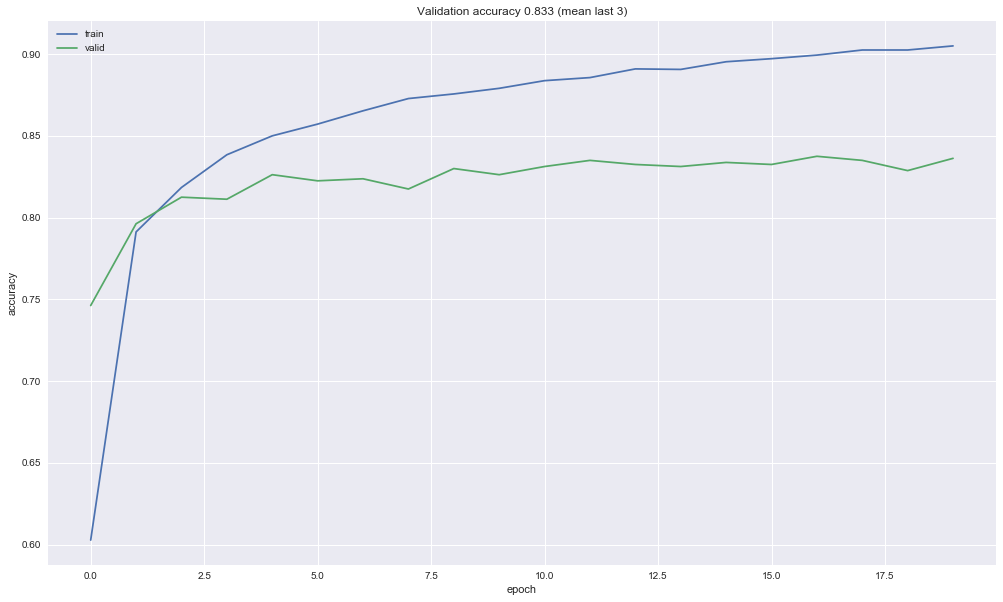

In [73]:
sns.set()
fig = plt.figure(figsize=(17, 10))
# Plot training curves
plt.plot(train_acc_values, label='train')
plt.plot(valid_acc_values, label='valid')
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The network is overfitting quite early but still overpass 80% that is a good score.